In [273]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics

import time
import os
import cv2


img_height = 64
img_width = 64
batch_size = 32

In [274]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='training_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 5064 files belonging to 2 classes.


In [275]:
val_ds = keras.utils.image_dataset_from_directory(
    directory='validation_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 967 files belonging to 2 classes.


In [276]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 564 files belonging to 2 classes.


In [277]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 114216 files belonging to 2 classes.


In [278]:
class_names = train_ds.class_names
print(class_names)

['defect', 'normal']


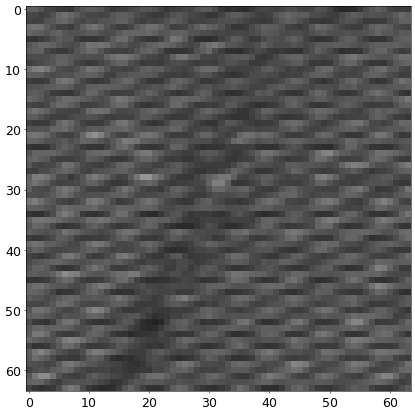

tf.Tensor(
[[[ 94.  94.  94.]
  [ 95.  95.  95.]
  [ 85.  85.  85.]
  ...
  [ 61.  61.  61.]
  [ 61.  61.  61.]
  [ 60.  60.  60.]]

 [[ 72.  72.  72.]
  [ 69.  69.  69.]
  [ 64.  64.  64.]
  ...
  [ 91.  91.  91.]
  [104. 104. 104.]
  [ 96.  96.  96.]]

 [[ 68.  68.  68.]
  [ 63.  63.  63.]
  [ 66.  66.  66.]
  ...
  [ 84.  84.  84.]
  [ 98.  98.  98.]
  [ 98.  98.  98.]]

 ...

 [[ 90.  90.  90.]
  [118. 118. 118.]
  [138. 138. 138.]
  ...
  [106. 106. 106.]
  [ 79.  79.  79.]
  [ 71.  71.  71.]]

 [[ 98.  98.  98.]
  [102. 102. 102.]
  [100. 100. 100.]
  ...
  [ 74.  74.  74.]
  [ 63.  63.  63.]
  [ 68.  68.  68.]]

 [[ 66.  66.  66.]
  [ 55.  55.  55.]
  [ 49.  49.  49.]
  ...
  [ 62.  62.  62.]
  [ 77.  77.  77.]
  [ 91.  91.  91.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


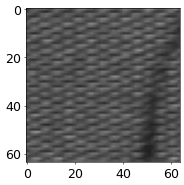

tf.Tensor(
[[[ 62.  62.  62.]
  [ 73.  73.  73.]
  [ 85.  85.  85.]
  ...
  [122. 122. 122.]
  [120. 120. 120.]
  [ 94.  94.  94.]]

 [[ 65.  65.  65.]
  [ 81.  81.  81.]
  [ 94.  94.  94.]
  ...
  [ 90.  90.  90.]
  [ 66.  66.  66.]
  [ 54.  54.  54.]]

 [[ 92.  92.  92.]
  [ 89.  89.  89.]
  [ 80.  80.  80.]
  ...
  [ 69.  69.  69.]
  [ 71.  71.  71.]
  [ 80.  80.  80.]]

 ...

 [[ 78.  78.  78.]
  [ 65.  65.  65.]
  [ 68.  68.  68.]
  ...
  [ 74.  74.  74.]
  [ 70.  70.  70.]
  [ 79.  79.  79.]]

 [[ 72.  72.  72.]
  [ 82.  82.  82.]
  [108. 108. 108.]
  ...
  [148. 148. 148.]
  [135. 135. 135.]
  [100. 100. 100.]]

 [[ 78.  78.  78.]
  [ 88.  88.  88.]
  [ 99.  99.  99.]
  ...
  [ 99.  99.  99.]
  [ 84.  84.  84.]
  [ 77.  77.  77.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


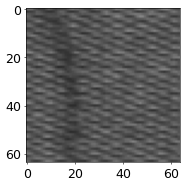

tf.Tensor(
[[[105. 105. 105.]
  [106. 106. 106.]
  [103. 103. 103.]
  ...
  [ 81.  81.  81.]
  [ 75.  75.  75.]
  [ 74.  74.  74.]]

 [[ 54.  54.  54.]
  [ 60.  60.  60.]
  [ 64.  64.  64.]
  ...
  [117. 117. 117.]
  [105. 105. 105.]
  [ 91.  91.  91.]]

 [[ 90.  90.  90.]
  [ 86.  86.  86.]
  [ 79.  79.  79.]
  ...
  [ 91.  91.  91.]
  [ 91.  91.  91.]
  [ 90.  90.  90.]]

 ...

 [[ 66.  66.  66.]
  [ 75.  75.  75.]
  [ 89.  89.  89.]
  ...
  [ 96.  96.  96.]
  [ 85.  85.  85.]
  [ 72.  72.  72.]]

 [[ 94.  94.  94.]
  [ 94.  94.  94.]
  [ 95.  95.  95.]
  ...
  [103. 103. 103.]
  [101. 101. 101.]
  [ 99.  99.  99.]]

 [[101. 101. 101.]
  [ 89.  89.  89.]
  [ 69.  69.  69.]
  ...
  [ 64.  64.  64.]
  [ 68.  68.  68.]
  [ 80.  80.  80.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


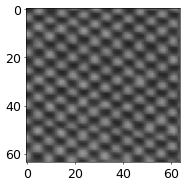

tf.Tensor(
[[[ 45.  45.  45.]
  [ 41.  41.  41.]
  [ 55.  55.  55.]
  ...
  [126. 126. 126.]
  [128. 128. 128.]
  [101. 101. 101.]]

 [[ 58.  58.  58.]
  [ 58.  58.  58.]
  [ 67.  67.  67.]
  ...
  [ 75.  75.  75.]
  [ 89.  89.  89.]
  [ 91.  91.  91.]]

 [[101. 101. 101.]
  [100. 100. 100.]
  [ 88.  88.  88.]
  ...
  [ 37.  37.  37.]
  [ 40.  40.  40.]
  [ 64.  64.  64.]]

 ...

 [[152. 152. 152.]
  [121. 121. 121.]
  [ 78.  78.  78.]
  ...
  [ 51.  51.  51.]
  [ 68.  68.  68.]
  [ 99.  99.  99.]]

 [[142. 142. 142.]
  [113. 113. 113.]
  [ 79.  79.  79.]
  ...
  [ 69.  69.  69.]
  [ 74.  74.  74.]
  [ 97.  97.  97.]]

 [[105. 105. 105.]
  [ 91.  91.  91.]
  [ 75.  75.  75.]
  ...
  [ 98.  98.  98.]
  [ 77.  77.  77.]
  [ 77.  77.  77.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


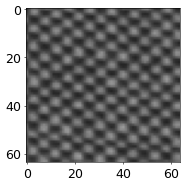

tf.Tensor(
[[[ 53.  53.  53.]
  [ 81.  81.  81.]
  [113. 113. 113.]
  ...
  [ 64.  64.  64.]
  [ 42.  42.  42.]
  [ 38.  38.  38.]]

 [[ 59.  59.  59.]
  [ 87.  87.  87.]
  [127. 127. 127.]
  ...
  [ 74.  74.  74.]
  [ 58.  58.  58.]
  [ 54.  54.  54.]]

 [[ 67.  67.  67.]
  [ 84.  84.  84.]
  [112. 112. 112.]
  ...
  [ 86.  86.  86.]
  [ 95.  95.  95.]
  [ 88.  88.  88.]]

 ...

 [[ 73.  73.  73.]
  [ 65.  65.  65.]
  [ 66.  66.  66.]
  ...
  [104. 104. 104.]
  [127. 127. 127.]
  [134. 134. 134.]]

 [[ 74.  74.  74.]
  [ 53.  53.  53.]
  [ 48.  48.  48.]
  ...
  [107. 107. 107.]
  [124. 124. 124.]
  [131. 131. 131.]]

 [[ 79.  79.  79.]
  [ 58.  58.  58.]
  [ 52.  52.  52.]
  ...
  [ 96.  96.  96.]
  [112. 112. 112.]
  [118. 118. 118.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


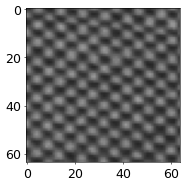

tf.Tensor(
[[[ 58.  58.  58.]
  [ 53.  53.  53.]
  [ 74.  74.  74.]
  ...
  [116. 116. 116.]
  [ 95.  95.  95.]
  [ 74.  74.  74.]]

 [[ 86.  86.  86.]
  [ 80.  80.  80.]
  [ 80.  80.  80.]
  ...
  [ 62.  62.  62.]
  [ 76.  76.  76.]
  [ 80.  80.  80.]]

 [[125. 125. 125.]
  [102. 102. 102.]
  [ 80.  80.  80.]
  ...
  [ 42.  42.  42.]
  [ 55.  55.  55.]
  [ 92.  92.  92.]]

 ...

 [[ 66.  66.  66.]
  [ 73.  73.  73.]
  [ 90.  90.  90.]
  ...
  [ 59.  59.  59.]
  [ 70.  70.  70.]
  [ 88.  88.  88.]]

 [[ 92.  92.  92.]
  [ 72.  72.  72.]
  [ 59.  59.  59.]
  ...
  [ 41.  41.  41.]
  [ 64.  64.  64.]
  [101. 101. 101.]]

 [[125. 125. 125.]
  [ 85.  85.  85.]
  [ 52.  52.  52.]
  ...
  [ 53.  53.  53.]
  [ 78.  78.  78.]
  [111. 111. 111.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


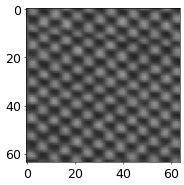

tf.Tensor(
[[[ 72.  72.  72.]
  [110. 110. 110.]
  [128. 128. 128.]
  ...
  [ 57.  57.  57.]
  [ 44.  44.  44.]
  [ 39.  39.  39.]]

 [[ 72.  72.  72.]
  [108. 108. 108.]
  [126. 126. 126.]
  ...
  [ 70.  70.  70.]
  [ 62.  62.  62.]
  [ 58.  58.  58.]]

 [[ 75.  75.  75.]
  [ 94.  94.  94.]
  [113. 113. 113.]
  ...
  [ 90.  90.  90.]
  [ 94.  94.  94.]
  [ 87.  87.  87.]]

 ...

 [[106. 106. 106.]
  [132. 132. 132.]
  [138. 138. 138.]
  ...
  [ 79.  79.  79.]
  [ 80.  80.  80.]
  [ 67.  67.  67.]]

 [[ 73.  73.  73.]
  [ 90.  90.  90.]
  [ 96.  96.  96.]
  ...
  [100. 100. 100.]
  [101. 101. 101.]
  [ 83.  83.  83.]]

 [[ 50.  50.  50.]
  [ 46.  46.  46.]
  [ 46.  46.  46.]
  ...
  [118. 118. 118.]
  [124. 124. 124.]
  [106. 106. 106.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


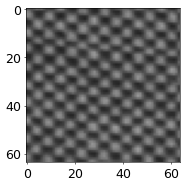

tf.Tensor(
[[[ 92.  92.  92.]
  [ 87.  87.  87.]
  [ 80.  80.  80.]
  ...
  [ 50.  50.  50.]
  [ 65.  65.  65.]
  [ 99.  99.  99.]]

 [[129. 129. 129.]
  [117. 117. 117.]
  [ 84.  84.  84.]
  ...
  [ 83.  83.  83.]
  [ 76.  76.  76.]
  [ 97.  97.  97.]]

 [[138. 138. 138.]
  [131. 131. 131.]
  [106. 106. 106.]
  ...
  [112. 112. 112.]
  [ 91.  91.  91.]
  [ 68.  68.  68.]]

 ...

 [[132. 132. 132.]
  [114. 114. 114.]
  [ 80.  80.  80.]
  ...
  [ 77.  77.  77.]
  [ 87.  87.  87.]
  [104. 104. 104.]]

 [[128. 128. 128.]
  [110. 110. 110.]
  [ 79.  79.  79.]
  ...
  [ 86.  86.  86.]
  [ 70.  70.  70.]
  [ 58.  58.  58.]]

 [[106. 106. 106.]
  [ 96.  96.  96.]
  [ 81.  81.  81.]
  ...
  [114. 114. 114.]
  [ 76.  76.  76.]
  [ 48.  48.  48.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


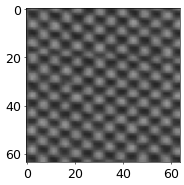

tf.Tensor(
[[[ 81.  81.  81.]
  [ 93.  93.  93.]
  [107. 107. 107.]
  ...
  [ 90.  90.  90.]
  [105. 105. 105.]
  [119. 119. 119.]]

 [[ 79.  79.  79.]
  [ 56.  56.  56.]
  [ 51.  51.  51.]
  ...
  [ 65.  65.  65.]
  [ 57.  57.  57.]
  [ 62.  62.  62.]]

 [[ 90.  90.  90.]
  [ 52.  52.  52.]
  [ 43.  43.  43.]
  ...
  [ 64.  64.  64.]
  [ 43.  43.  43.]
  [ 41.  41.  41.]]

 ...

 [[ 62.  62.  62.]
  [ 55.  55.  55.]
  [ 56.  56.  56.]
  ...
  [ 58.  58.  58.]
  [ 74.  74.  74.]
  [ 78.  78.  78.]]

 [[ 61.  61.  61.]
  [ 44.  44.  44.]
  [ 37.  37.  37.]
  ...
  [ 45.  45.  45.]
  [ 39.  39.  39.]
  [ 38.  38.  38.]]

 [[ 68.  68.  68.]
  [ 63.  63.  63.]
  [ 57.  57.  57.]
  ...
  [ 60.  60.  60.]
  [ 55.  55.  55.]
  [ 44.  44.  44.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


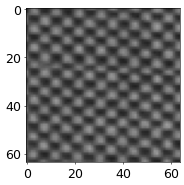

tf.Tensor(
[[[ 46.  46.  46.]
  [ 81.  81.  81.]
  [114. 114. 114.]
  ...
  [ 79.  79.  79.]
  [111. 111. 111.]
  [130. 130. 130.]]

 [[ 50.  50.  50.]
  [ 87.  87.  87.]
  [114. 114. 114.]
  ...
  [ 82.  82.  82.]
  [109. 109. 109.]
  [123. 123. 123.]]

 [[ 78.  78.  78.]
  [ 92.  92.  92.]
  [104. 104. 104.]
  ...
  [ 82.  82.  82.]
  [ 79.  79.  79.]
  [ 90.  90.  90.]]

 ...

 [[ 83.  83.  83.]
  [112. 112. 112.]
  [135. 135. 135.]
  ...
  [ 98.  98.  98.]
  [119. 119. 119.]
  [125. 125. 125.]]

 [[ 76.  76.  76.]
  [ 88.  88.  88.]
  [ 95.  95.  95.]
  ...
  [ 69.  69.  69.]
  [ 72.  72.  72.]
  [ 76.  76.  76.]]

 [[ 77.  77.  77.]
  [ 57.  57.  57.]
  [ 56.  56.  56.]
  ...
  [ 50.  50.  50.]
  [ 38.  38.  38.]
  [ 37.  37.  37.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


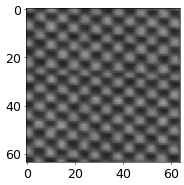

tf.Tensor(
[[[117. 117. 117.]
  [128. 128. 128.]
  [118. 118. 118.]
  ...
  [ 86.  86.  86.]
  [102. 102. 102.]
  [ 98.  98.  98.]]

 [[ 77.  77.  77.]
  [ 89.  89.  89.]
  [ 87.  87.  87.]
  ...
  [ 41.  41.  41.]
  [ 45.  45.  45.]
  [ 59.  59.  59.]]

 [[ 40.  40.  40.]
  [ 43.  43.  43.]
  [ 42.  42.  42.]
  ...
  [ 45.  45.  45.]
  [ 42.  42.  42.]
  [ 59.  59.  59.]]

 ...

 [[ 75.  75.  75.]
  [ 86.  86.  86.]
  [ 84.  84.  84.]
  ...
  [ 44.  44.  44.]
  [ 47.  47.  47.]
  [ 66.  66.  66.]]

 [[ 38.  38.  38.]
  [ 38.  38.  38.]
  [ 52.  52.  52.]
  ...
  [ 34.  34.  34.]
  [ 37.  37.  37.]
  [ 61.  61.  61.]]

 [[ 47.  47.  47.]
  [ 43.  43.  43.]
  [ 48.  48.  48.]
  ...
  [ 51.  51.  51.]
  [ 49.  49.  49.]
  [ 72.  72.  72.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


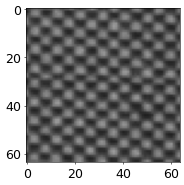

tf.Tensor(
[[[ 56.  56.  56.]
  [ 70.  70.  70.]
  [ 93.  93.  93.]
  ...
  [ 42.  42.  42.]
  [ 78.  78.  78.]
  [114. 114. 114.]]

 [[ 37.  37.  37.]
  [ 69.  69.  69.]
  [115. 115. 115.]
  ...
  [ 58.  58.  58.]
  [ 83.  83.  83.]
  [110. 110. 110.]]

 [[ 61.  61.  61.]
  [ 84.  84.  84.]
  [120. 120. 120.]
  ...
  [ 72.  72.  72.]
  [ 76.  76.  76.]
  [ 78.  78.  78.]]

 ...

 [[ 56.  56.  56.]
  [ 92.  92.  92.]
  [124. 124. 124.]
  ...
  [ 65.  65.  65.]
  [102. 102. 102.]
  [133. 133. 133.]]

 [[ 67.  67.  67.]
  [ 97.  97.  97.]
  [125. 125. 125.]
  ...
  [ 76.  76.  76.]
  [ 83.  83.  83.]
  [ 98.  98.  98.]]

 [[ 80.  80.  80.]
  [ 94.  94.  94.]
  [101. 101. 101.]
  ...
  [ 75.  75.  75.]
  [ 53.  53.  53.]
  [ 46.  46.  46.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


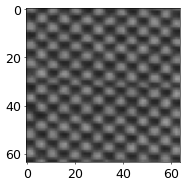

tf.Tensor(
[[[112. 112. 112.]
  [129. 129. 129.]
  [132. 132. 132.]
  ...
  [ 91.  91.  91.]
  [ 99.  99.  99.]
  [100. 100. 100.]]

 [[ 88.  88.  88.]
  [ 95.  95.  95.]
  [102. 102. 102.]
  ...
  [ 58.  58.  58.]
  [ 54.  54.  54.]
  [ 52.  52.  52.]]

 [[ 56.  56.  56.]
  [ 48.  48.  48.]
  [ 51.  51.  51.]
  ...
  [ 54.  54.  54.]
  [ 49.  49.  49.]
  [ 42.  42.  42.]]

 ...

 [[113. 113. 113.]
  [123. 123. 123.]
  [116. 116. 116.]
  ...
  [ 61.  61.  61.]
  [ 60.  60.  60.]
  [ 63.  63.  63.]]

 [[ 57.  57.  57.]
  [ 58.  58.  58.]
  [ 58.  58.  58.]
  ...
  [ 42.  42.  42.]
  [ 37.  37.  37.]
  [ 39.  39.  39.]]

 [[ 44.  44.  44.]
  [ 37.  37.  37.]
  [ 37.  37.  37.]
  ...
  [ 63.  63.  63.]
  [ 57.  57.  57.]
  [ 50.  50.  50.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


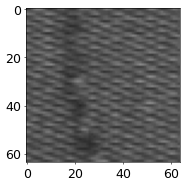

tf.Tensor(
[[[ 60.  60.  60.]
  [ 67.  67.  67.]
  [ 88.  88.  88.]
  ...
  [113. 113. 113.]
  [106. 106. 106.]
  [ 95.  95.  95.]]

 [[ 98.  98.  98.]
  [ 89.  89.  89.]
  [ 85.  85.  85.]
  ...
  [ 75.  75.  75.]
  [ 83.  83.  83.]
  [ 80.  80.  80.]]

 [[121. 121. 121.]
  [113. 113. 113.]
  [106. 106. 106.]
  ...
  [ 76.  76.  76.]
  [ 78.  78.  78.]
  [ 83.  83.  83.]]

 ...

 [[ 86.  86.  86.]
  [ 75.  75.  75.]
  [ 65.  65.  65.]
  ...
  [ 68.  68.  68.]
  [ 72.  72.  72.]
  [ 76.  76.  76.]]

 [[119. 119. 119.]
  [105. 105. 105.]
  [ 80.  80.  80.]
  ...
  [ 66.  66.  66.]
  [ 66.  66.  66.]
  [ 74.  74.  74.]]

 [[ 71.  71.  71.]
  [ 75.  75.  75.]
  [ 84.  84.  84.]
  ...
  [ 98.  98.  98.]
  [ 86.  86.  86.]
  [ 68.  68.  68.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


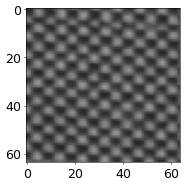

tf.Tensor(
[[[ 44.  44.  44.]
  [ 43.  43.  43.]
  [ 53.  53.  53.]
  ...
  [ 39.  39.  39.]
  [ 42.  42.  42.]
  [ 67.  67.  67.]]

 [[ 45.  45.  45.]
  [ 45.  45.  45.]
  [ 56.  56.  56.]
  ...
  [ 47.  47.  47.]
  [ 49.  49.  49.]
  [ 75.  75.  75.]]

 [[ 60.  60.  60.]
  [ 58.  58.  58.]
  [ 64.  64.  64.]
  ...
  [ 74.  74.  74.]
  [ 67.  67.  67.]
  [ 77.  77.  77.]]

 ...

 [[ 46.  46.  46.]
  [ 59.  59.  59.]
  [ 94.  94.  94.]
  ...
  [ 55.  55.  55.]
  [ 65.  65.  65.]
  [ 97.  97.  97.]]

 [[ 70.  70.  70.]
  [ 68.  68.  68.]
  [ 94.  94.  94.]
  ...
  [ 92.  92.  92.]
  [ 79.  79.  79.]
  [ 86.  86.  86.]]

 [[116. 116. 116.]
  [ 98.  98.  98.]
  [ 87.  87.  87.]
  ...
  [126. 126. 126.]
  [ 90.  90.  90.]
  [ 57.  57.  57.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


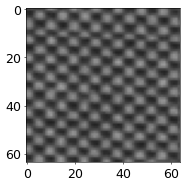

tf.Tensor(
[[[69. 69. 69.]
  [68. 68. 68.]
  [72. 72. 72.]
  ...
  [62. 62. 62.]
  [66. 66. 66.]
  [72. 72. 72.]]

 [[42. 42. 42.]
  [39. 39. 39.]
  [45. 45. 45.]
  ...
  [47. 47. 47.]
  [43. 43. 43.]
  [61. 61. 61.]]

 [[47. 47. 47.]
  [39. 39. 39.]
  [46. 46. 46.]
  ...
  [59. 59. 59.]
  [57. 57. 57.]
  [68. 68. 68.]]

 ...

 [[44. 44. 44.]
  [44. 44. 44.]
  [58. 58. 58.]
  ...
  [40. 40. 40.]
  [47. 47. 47.]
  [74. 74. 74.]]

 [[45. 45. 45.]
  [38. 38. 38.]
  [59. 59. 59.]
  ...
  [57. 57. 57.]
  [57. 57. 57.]
  [74. 74. 74.]]

 [[63. 63. 63.]
  [67. 67. 67.]
  [73. 73. 73.]
  ...
  [82. 82. 82.]
  [74. 74. 74.]
  [65. 65. 65.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


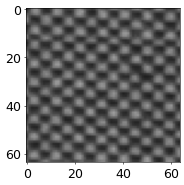

tf.Tensor(
[[[ 46.  46.  46.]
  [ 71.  71.  71.]
  [118. 118. 118.]
  ...
  [ 58.  58.  58.]
  [ 83.  83.  83.]
  [118. 118. 118.]]

 [[ 60.  60.  60.]
  [ 85.  85.  85.]
  [117. 117. 117.]
  ...
  [ 78.  78.  78.]
  [ 75.  75.  75.]
  [ 87.  87.  87.]]

 [[ 91.  91.  91.]
  [ 88.  88.  88.]
  [102. 102. 102.]
  ...
  [101. 101. 101.]
  [ 65.  65.  65.]
  [ 48.  48.  48.]]

 ...

 [[ 75.  75.  75.]
  [113. 113. 113.]
  [145. 145. 145.]
  ...
  [ 94.  94.  94.]
  [101. 101. 101.]
  [120. 120. 120.]]

 [[ 83.  83.  83.]
  [ 91.  91.  91.]
  [110. 110. 110.]
  ...
  [ 92.  92.  92.]
  [ 74.  74.  74.]
  [ 69.  69.  69.]]

 [[ 94.  94.  94.]
  [ 61.  61.  61.]
  [ 56.  56.  56.]
  ...
  [109. 109. 109.]
  [ 64.  64.  64.]
  [ 45.  45.  45.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


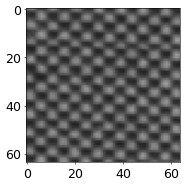

tf.Tensor(
[[[110. 110. 110.]
  [118. 118. 118.]
  [123. 123. 123.]
  ...
  [ 48.  48.  48.]
  [ 46.  46.  46.]
  [ 50.  50.  50.]]

 [[ 61.  61.  61.]
  [ 63.  63.  63.]
  [ 63.  63.  63.]
  ...
  [ 59.  59.  59.]
  [ 47.  47.  47.]
  [ 38.  38.  38.]]

 [[ 50.  50.  50.]
  [ 43.  43.  43.]
  [ 38.  38.  38.]
  ...
  [ 60.  60.  60.]
  [ 60.  60.  60.]
  [ 60.  60.  60.]]

 ...

 [[ 51.  51.  51.]
  [ 56.  56.  56.]
  [ 60.  60.  60.]
  ...
  [ 46.  46.  46.]
  [ 41.  41.  41.]
  [ 43.  43.  43.]]

 [[ 42.  42.  42.]
  [ 38.  38.  38.]
  [ 36.  36.  36.]
  ...
  [ 63.  63.  63.]
  [ 56.  56.  56.]
  [ 50.  50.  50.]]

 [[ 54.  54.  54.]
  [ 50.  50.  50.]
  [ 51.  51.  51.]
  ...
  [ 77.  77.  77.]
  [ 88.  88.  88.]
  [ 87.  87.  87.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


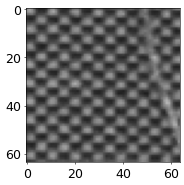

tf.Tensor(
[[[144. 144. 144.]
  [164. 164. 164.]
  [145. 145. 145.]
  ...
  [106. 106. 106.]
  [118. 118. 118.]
  [122. 122. 122.]]

 [[142. 142. 142.]
  [157. 157. 157.]
  [144. 144. 144.]
  ...
  [ 52.  52.  52.]
  [ 51.  51.  51.]
  [ 48.  48.  48.]]

 [[111. 111. 111.]
  [117. 117. 117.]
  [117. 117. 117.]
  ...
  [ 50.  50.  50.]
  [ 42.  42.  42.]
  [ 39.  39.  39.]]

 ...

 [[129. 129. 129.]
  [145. 145. 145.]
  [152. 152. 152.]
  ...
  [ 75.  75.  75.]
  [ 68.  68.  68.]
  [ 59.  59.  59.]]

 [[103. 103. 103.]
  [117. 117. 117.]
  [122. 122. 122.]
  ...
  [ 56.  56.  56.]
  [ 47.  47.  47.]
  [ 39.  39.  39.]]

 [[ 58.  58.  58.]
  [ 55.  55.  55.]
  [ 63.  63.  63.]
  ...
  [ 64.  64.  64.]
  [ 59.  59.  59.]
  [ 52.  52.  52.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


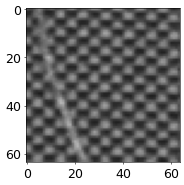

tf.Tensor(
[[[ 85.  85.  85.]
  [ 73.  73.  73.]
  [ 72.  72.  72.]
  ...
  [ 45.  45.  45.]
  [ 52.  52.  52.]
  [ 61.  61.  61.]]

 [[ 43.  43.  43.]
  [ 41.  41.  41.]
  [ 56.  56.  56.]
  ...
  [ 75.  75.  75.]
  [ 75.  75.  75.]
  [ 79.  79.  79.]]

 [[ 40.  40.  40.]
  [ 44.  44.  44.]
  [ 67.  67.  67.]
  ...
  [ 94.  94.  94.]
  [ 90.  90.  90.]
  [ 78.  78.  78.]]

 ...

 [[ 45.  45.  45.]
  [ 41.  41.  41.]
  [ 72.  72.  72.]
  ...
  [ 89.  89.  89.]
  [ 74.  74.  74.]
  [ 71.  71.  71.]]

 [[ 52.  52.  52.]
  [ 51.  51.  51.]
  [ 80.  80.  80.]
  ...
  [111. 111. 111.]
  [ 85.  85.  85.]
  [ 68.  68.  68.]]

 [[ 82.  82.  82.]
  [ 80.  80.  80.]
  [ 94.  94.  94.]
  ...
  [130. 130. 130.]
  [118. 118. 118.]
  [ 73.  73.  73.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


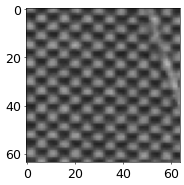

tf.Tensor(
[[[122. 122. 122.]
  [142. 142. 142.]
  [138. 138. 138.]
  ...
  [ 51.  51.  51.]
  [ 43.  43.  43.]
  [ 39.  39.  39.]]

 [[105. 105. 105.]
  [105. 105. 105.]
  [101. 101. 101.]
  ...
  [ 52.  52.  52.]
  [ 38.  38.  38.]
  [ 37.  37.  37.]]

 [[ 51.  51.  51.]
  [ 46.  46.  46.]
  [ 44.  44.  44.]
  ...
  [ 60.  60.  60.]
  [ 53.  53.  53.]
  [ 59.  59.  59.]]

 ...

 [[110. 110. 110.]
  [129. 129. 129.]
  [131. 131. 131.]
  ...
  [ 54.  54.  54.]
  [ 38.  38.  38.]
  [ 38.  38.  38.]]

 [[ 59.  59.  59.]
  [ 62.  62.  62.]
  [ 69.  69.  69.]
  ...
  [ 71.  71.  71.]
  [ 62.  62.  62.]
  [ 63.  63.  63.]]

 [[ 58.  58.  58.]
  [ 51.  51.  51.]
  [ 55.  55.  55.]
  ...
  [ 93.  93.  93.]
  [100. 100. 100.]
  [ 97.  97.  97.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


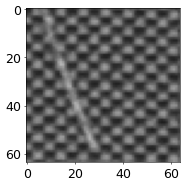

tf.Tensor(
[[[ 34.  34.  34.]
  [ 39.  39.  39.]
  [ 68.  68.  68.]
  ...
  [ 76.  76.  76.]
  [ 63.  63.  63.]
  [ 70.  70.  70.]]

 [[ 44.  44.  44.]
  [ 49.  49.  49.]
  [ 82.  82.  82.]
  ...
  [112. 112. 112.]
  [107. 107. 107.]
  [ 74.  74.  74.]]

 [[ 59.  59.  59.]
  [ 73.  73.  73.]
  [ 92.  92.  92.]
  ...
  [147. 147. 147.]
  [144. 144. 144.]
  [ 99.  99.  99.]]

 ...

 [[ 49.  49.  49.]
  [ 51.  51.  51.]
  [ 82.  82.  82.]
  ...
  [135. 135. 135.]
  [119. 119. 119.]
  [ 84.  84.  84.]]

 [[ 76.  76.  76.]
  [ 81.  81.  81.]
  [ 94.  94.  94.]
  ...
  [154. 154. 154.]
  [144. 144. 144.]
  [106. 106. 106.]]

 [[118. 118. 118.]
  [119. 119. 119.]
  [103. 103. 103.]
  ...
  [151. 151. 151.]
  [143. 143. 143.]
  [111. 111. 111.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


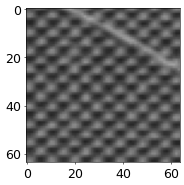

tf.Tensor(
[[[ 82.  82.  82.]
  [ 79.  79.  79.]
  [ 80.  80.  80.]
  ...
  [119. 119. 119.]
  [132. 132. 132.]
  [128. 128. 128.]]

 [[ 99.  99.  99.]
  [101. 101. 101.]
  [ 89.  89.  89.]
  ...
  [ 92.  92.  92.]
  [ 90.  90.  90.]
  [ 86.  86.  86.]]

 [[120. 120. 120.]
  [123. 123. 123.]
  [117. 117. 117.]
  ...
  [ 53.  53.  53.]
  [ 42.  42.  42.]
  [ 43.  43.  43.]]

 ...

 [[ 80.  80.  80.]
  [ 88.  88.  88.]
  [ 83.  83.  83.]
  ...
  [104. 104. 104.]
  [115. 115. 115.]
  [106. 106. 106.]]

 [[107. 107. 107.]
  [114. 114. 114.]
  [110. 110. 110.]
  ...
  [ 65.  65.  65.]
  [ 56.  56.  56.]
  [ 53.  53.  53.]]

 [[120. 120. 120.]
  [134. 134. 134.]
  [121. 121. 121.]
  ...
  [ 50.  50.  50.]
  [ 38.  38.  38.]
  [ 39.  39.  39.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


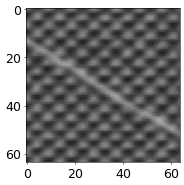

tf.Tensor(
[[[124. 124. 124.]
  [105. 105. 105.]
  [ 83.  83.  83.]
  ...
  [ 57.  57.  57.]
  [ 72.  72.  72.]
  [ 94.  94.  94.]]

 [[ 74.  74.  74.]
  [ 67.  67.  67.]
  [ 64.  64.  64.]
  ...
  [ 67.  67.  67.]
  [ 75.  75.  75.]
  [ 90.  90.  90.]]

 [[ 41.  41.  41.]
  [ 51.  51.  51.]
  [ 72.  72.  72.]
  ...
  [ 94.  94.  94.]
  [ 86.  86.  86.]
  [ 73.  73.  73.]]

 ...

 [[ 94.  94.  94.]
  [ 88.  88.  88.]
  [ 83.  83.  83.]
  ...
  [ 62.  62.  62.]
  [ 72.  72.  72.]
  [ 84.  84.  84.]]

 [[ 51.  51.  51.]
  [ 61.  61.  61.]
  [ 81.  81.  81.]
  ...
  [ 87.  87.  87.]
  [ 86.  86.  86.]
  [ 85.  85.  85.]]

 [[ 45.  45.  45.]
  [ 68.  68.  68.]
  [ 92.  92.  92.]
  ...
  [115. 115. 115.]
  [101. 101. 101.]
  [ 78.  78.  78.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


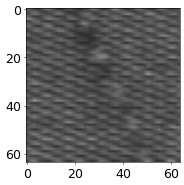

tf.Tensor(
[[[104. 104. 104.]
  [ 90.  90.  90.]
  [ 78.  78.  78.]
  ...
  [ 66.  66.  66.]
  [ 64.  64.  64.]
  [ 83.  83.  83.]]

 [[ 75.  75.  75.]
  [ 87.  87.  87.]
  [ 94.  94.  94.]
  ...
  [ 84.  84.  84.]
  [ 84.  84.  84.]
  [ 78.  78.  78.]]

 [[ 73.  73.  73.]
  [ 82.  82.  82.]
  [101. 101. 101.]
  ...
  [117. 117. 117.]
  [102. 102. 102.]
  [ 82.  82.  82.]]

 ...

 [[ 93.  93.  93.]
  [ 76.  76.  76.]
  [ 65.  65.  65.]
  ...
  [ 71.  71.  71.]
  [ 88.  88.  88.]
  [101. 101. 101.]]

 [[ 98.  98.  98.]
  [ 99.  99.  99.]
  [100. 100. 100.]
  ...
  [ 81.  81.  81.]
  [ 78.  78.  78.]
  [ 80.  80.  80.]]

 [[ 70.  70.  70.]
  [ 91.  91.  91.]
  [113. 113. 113.]
  ...
  [118. 118. 118.]
  [ 82.  82.  82.]
  [ 63.  63.  63.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


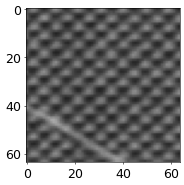

tf.Tensor(
[[[ 73.  73.  73.]
  [106. 106. 106.]
  [129. 129. 129.]
  ...
  [ 81.  81.  81.]
  [ 55.  55.  55.]
  [ 39.  39.  39.]]

 [[ 86.  86.  86.]
  [ 99.  99.  99.]
  [110. 110. 110.]
  ...
  [ 90.  90.  90.]
  [ 66.  66.  66.]
  [ 60.  60.  60.]]

 [[ 83.  83.  83.]
  [ 65.  65.  65.]
  [ 61.  61.  61.]
  ...
  [ 68.  68.  68.]
  [ 74.  74.  74.]
  [ 87.  87.  87.]]

 ...

 [[ 85.  85.  85.]
  [108. 108. 108.]
  [119. 119. 119.]
  ...
  [ 94.  94.  94.]
  [ 64.  64.  64.]
  [ 52.  52.  52.]]

 [[ 81.  81.  81.]
  [ 75.  75.  75.]
  [ 73.  73.  73.]
  ...
  [ 88.  88.  88.]
  [ 78.  78.  78.]
  [ 67.  67.  67.]]

 [[ 80.  80.  80.]
  [ 54.  54.  54.]
  [ 46.  46.  46.]
  ...
  [ 71.  71.  71.]
  [ 75.  75.  75.]
  [ 81.  81.  81.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


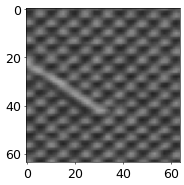

tf.Tensor(
[[[ 66.  66.  66.]
  [ 63.  63.  63.]
  [ 70.  70.  70.]
  ...
  [ 74.  74.  74.]
  [ 83.  83.  83.]
  [ 88.  88.  88.]]

 [[ 41.  41.  41.]
  [ 44.  44.  44.]
  [ 52.  52.  52.]
  ...
  [ 87.  87.  87.]
  [ 97.  97.  97.]
  [ 88.  88.  88.]]

 [[ 50.  50.  50.]
  [ 49.  49.  49.]
  [ 62.  62.  62.]
  ...
  [109. 109. 109.]
  [124. 124. 124.]
  [114. 114. 114.]]

 ...

 [[ 85.  85.  85.]
  [ 91.  91.  91.]
  [ 96.  96.  96.]
  ...
  [123. 123. 123.]
  [134. 134. 134.]
  [125. 125. 125.]]

 [[103. 103. 103.]
  [106. 106. 106.]
  [ 97.  97.  97.]
  ...
  [100. 100. 100.]
  [ 95.  95.  95.]
  [ 98.  98.  98.]]

 [[123. 123. 123.]
  [129. 129. 129.]
  [107. 107. 107.]
  ...
  [ 53.  53.  53.]
  [ 47.  47.  47.]
  [ 53.  53.  53.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


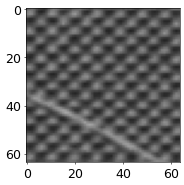

tf.Tensor(
[[[ 99.  99.  99.]
  [107. 107. 107.]
  [110. 110. 110.]
  ...
  [109. 109. 109.]
  [109. 109. 109.]
  [107. 107. 107.]]

 [[122. 122. 122.]
  [135. 135. 135.]
  [125. 125. 125.]
  ...
  [ 51.  51.  51.]
  [ 50.  50.  50.]
  [ 53.  53.  53.]]

 [[128. 128. 128.]
  [139. 139. 139.]
  [132. 132. 132.]
  ...
  [ 50.  50.  50.]
  [ 48.  48.  48.]
  [ 55.  55.  55.]]

 ...

 [[117. 117. 117.]
  [131. 131. 131.]
  [129. 129. 129.]
  ...
  [ 54.  54.  54.]
  [ 41.  41.  41.]
  [ 49.  49.  49.]]

 [[124. 124. 124.]
  [137. 137. 137.]
  [117. 117. 117.]
  ...
  [ 55.  55.  55.]
  [ 47.  47.  47.]
  [ 54.  54.  54.]]

 [[ 96.  96.  96.]
  [ 92.  92.  92.]
  [ 84.  84.  84.]
  ...
  [ 65.  65.  65.]
  [ 56.  56.  56.]
  [ 67.  67.  67.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


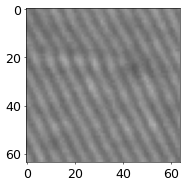

tf.Tensor(
[[[135. 135. 135.]
  [116. 116. 116.]
  [115. 115. 115.]
  ...
  [125. 125. 125.]
  [122. 122. 122.]
  [134. 134. 134.]]

 [[135. 135. 135.]
  [125. 125. 125.]
  [117. 117. 117.]
  ...
  [134. 134. 134.]
  [120. 120. 120.]
  [124. 124. 124.]]

 [[136. 136. 136.]
  [130. 130. 130.]
  [114. 114. 114.]
  ...
  [139. 139. 139.]
  [114. 114. 114.]
  [117. 117. 117.]]

 ...

 [[150. 150. 150.]
  [134. 134. 134.]
  [118. 118. 118.]
  ...
  [124. 124. 124.]
  [108. 108. 108.]
  [124. 124. 124.]]

 [[149. 149. 149.]
  [138. 138. 138.]
  [121. 121. 121.]
  ...
  [141. 141. 141.]
  [115. 115. 115.]
  [109. 109. 109.]]

 [[143. 143. 143.]
  [144. 144. 144.]
  [127. 127. 127.]
  ...
  [142. 142. 142.]
  [120. 120. 120.]
  [112. 112. 112.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


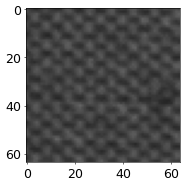

tf.Tensor(
[[[71. 71. 71.]
  [59. 59. 59.]
  [53. 53. 53.]
  ...
  [70. 70. 70.]
  [75. 75. 75.]
  [70. 70. 70.]]

 [[74. 74. 74.]
  [67. 67. 67.]
  [62. 62. 62.]
  ...
  [75. 75. 75.]
  [88. 88. 88.]
  [87. 87. 87.]]

 [[63. 63. 63.]
  [70. 70. 70.]
  [75. 75. 75.]
  ...
  [78. 78. 78.]
  [88. 88. 88.]
  [96. 96. 96.]]

 ...

 [[54. 54. 54.]
  [60. 60. 60.]
  [76. 76. 76.]
  ...
  [70. 70. 70.]
  [89. 89. 89.]
  [89. 89. 89.]]

 [[50. 50. 50.]
  [61. 61. 61.]
  [71. 71. 71.]
  ...
  [70. 70. 70.]
  [80. 80. 80.]
  [77. 77. 77.]]

 [[61. 61. 61.]
  [64. 64. 64.]
  [72. 72. 72.]
  ...
  [61. 61. 61.]
  [62. 62. 62.]
  [60. 60. 60.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


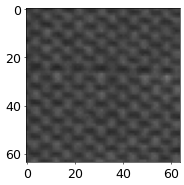

tf.Tensor(
[[[53. 53. 53.]
  [52. 52. 52.]
  [59. 59. 59.]
  ...
  [67. 67. 67.]
  [72. 72. 72.]
  [70. 70. 70.]]

 [[64. 64. 64.]
  [61. 61. 61.]
  [63. 63. 63.]
  ...
  [59. 59. 59.]
  [64. 64. 64.]
  [61. 61. 61.]]

 [[76. 76. 76.]
  [68. 68. 68.]
  [58. 58. 58.]
  ...
  [54. 54. 54.]
  [49. 49. 49.]
  [46. 46. 46.]]

 ...

 [[76. 76. 76.]
  [66. 66. 66.]
  [61. 61. 61.]
  ...
  [82. 82. 82.]
  [91. 91. 91.]
  [80. 80. 80.]]

 [[67. 67. 67.]
  [69. 69. 69.]
  [72. 72. 72.]
  ...
  [85. 85. 85.]
  [89. 89. 89.]
  [87. 87. 87.]]

 [[62. 62. 62.]
  [71. 71. 71.]
  [86. 86. 86.]
  ...
  [85. 85. 85.]
  [93. 93. 93.]
  [88. 88. 88.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


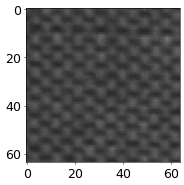

tf.Tensor(
[[[84. 84. 84.]
  [64. 64. 64.]
  [58. 58. 58.]
  ...
  [58. 58. 58.]
  [56. 56. 56.]
  [52. 52. 52.]]

 [[77. 77. 77.]
  [64. 64. 64.]
  [59. 59. 59.]
  ...
  [71. 71. 71.]
  [74. 74. 74.]
  [72. 72. 72.]]

 [[67. 67. 67.]
  [63. 63. 63.]
  [62. 62. 62.]
  ...
  [82. 82. 82.]
  [88. 88. 88.]
  [90. 90. 90.]]

 ...

 [[50. 50. 50.]
  [65. 65. 65.]
  [75. 75. 75.]
  ...
  [80. 80. 80.]
  [88. 88. 88.]
  [86. 86. 86.]]

 [[55. 55. 55.]
  [62. 62. 62.]
  [68. 68. 68.]
  ...
  [72. 72. 72.]
  [76. 76. 76.]
  [70. 70. 70.]]

 [[67. 67. 67.]
  [62. 62. 62.]
  [72. 72. 72.]
  ...
  [47. 47. 47.]
  [49. 49. 49.]
  [48. 48. 48.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


In [279]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi']     = 50

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(0, len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.show()
        print(images[i])
        print(labels[i])
        print("-----------------------------")
    

In [280]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [281]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])



In [282]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)      

In [283]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

Epoch 1/15
159/159 [==============================] - 35s 185ms/step - loss: 0.6662 - accuracy: 0.7107 - val_loss: 0.5365 - val_accuracy: 0.8438
Epoch 2/15
159/159 [==============================] - 26s 165ms/step - loss: 0.5915 - accuracy: 0.7344 - val_loss: 0.5429 - val_accuracy: 0.8438
Epoch 3/15
159/159 [==============================] - 29s 183ms/step - loss: 0.6289 - accuracy: 0.7344 - val_loss: 0.4905 - val_accuracy: 0.8438
Epoch 4/15
159/159 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.7344

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.rcParams['font.size'] = 18

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
result = model.evaluate(test_ds)
dict(zip(mode``l.metrics_names, result))

In [267]:
# cwd = os.getcwd()
model.save("inspection_model")



KeyboardInterrupt: 

 # Traing with Aug

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
#   layers.Dense(1)
])



In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

In [ ]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.rcParams['font.size'] = 18

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.rcParams['font.size'] = 18

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("inspection_model_aug")


# ROC no aug

In [ ]:
model.save("inspection_model_aug")


In [ ]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

In [ ]:
path = "./test_data/defect/defect_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)
print("inference took:", timeTaken,"ms")

In [ ]:
# dad got an accarcy of 93% on inspections machines without ai

# More Testing without data augmentation

In [ ]:
# loading 


reconstructed_model = keras.models.load_model("inspection_model")


Have to change batchsize to properly inspect, not needed if data isnt shuffled

# ROC no aug

In [ ]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
#tpr, fpr, thresholds = metrics.roc_curve(targets, predictions)
print(tpr)
print(len(tpr))
print("--------------------")
print(fpr)
print(len(fpr))
print("--------------------")
print(thresholds)
print("--------------------")
print(metrics.roc_auc_score(targets, predictions))
print("--------------------")
optimal_idx = np.argmax(tpr - fpr)
print(optimal_idx)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)


In [ ]:
from sklearn.metrics import classification_report
 

print(classification_report(targets, roundedPredictions))

In [ ]:

# result = reconstructed_model.evaluate(all_ds)

# dict(zip(reconstructed_model.metrics_names, result))

In [ ]:
# all_ds = keras.utils.image_dataset_from_directory(
#     directory='tiles/',
#     labels='inferred',
#     label_mode='binary',
#     batch_size=batch_size,
#     image_size=(img_height, img_width),
#     shuffle=False
# )

In [ ]:
# predictions = reconstructed_model.predict(all_ds)


# roundedPredictions = []
# for p in predictions:
#     roundedPredictions.append(int(np.rint(p[0])))

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# targets = np.concatenate([targets for features, targets in all_ds], axis=0)


# cm = confusion_matrix(targets, roundedPredictions)
# #print(cm)

# #print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))

# plt.figure(figsize=(20,10)) 
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
# disp.plot()
# plt.show()

# f,ax = plt.subplots(1,1,figsize=(8,8))
# plt.rcParams['font.size'] = 18
# disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
# plt.show()

# With Data Augmetation

In [ ]:
reconstructed_model = keras.models.load_model("inspection_model_aug")


In [ ]:
result = reconstructed_model.evaluate(test_ds)


In [ ]:
predictions = reconstructed_model.predict(test_ds)

targets = np.concatenate([targets for features, targets in test_ds], axis=0)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

In [ ]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
#tpr, fpr, thresholds = metrics.roc_curve(targets, predictions)
print(tpr)
print(len(tpr))
print("--------------------")
print(fpr)
print(len(fpr))
print("--------------------")
print(thresholds)
print("--------------------")
print(metrics.roc_auc_score(targets, predictions))
print("--------------------")
optimal_idx = np.argmax(tpr - fpr)
print(optimal_idx)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)


In [ ]:
# result = reconstructed_model.evaluate(all_ds)

# dict(zip(reconstructed_model.metrics_names, result))

In [ ]:
# predictions = reconstructed_model.predict(all_ds)


# roundedPredictions = []
# for p in predictions:
#     roundedPredictions.append(int(np.rint(p[0])))

In [ ]:
# targets = np.concatenate([targets for features, targets in all_ds], axis=0)

# fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
# roc_auc = metrics.auc(fpr, tpr)
# plt.figure(figsize=(8, 6), dpi=80)
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# print(classification_report(targets, predictions))

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# targets = np.concatenate([targets for features, targets in all_ds], axis=0)


# cm = confusion_matrix(targets, roundedPredictions)
# print(cm)

# print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))



In [ ]:
# plt.figure(figsize=(20,10)) 
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
# disp.plot()
# plt.show()

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

# With confidence 0.14092079 cutoff No aug

In [ ]:
reconstructed_model = keras.models.load_model("inspection_model")

predictions = reconstructed_model.predict(test_ds)

print("predictions done")



In [ ]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.14092079:
        p_temp = 1
    roundedPredictions.append(p_temp)

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# targets = np.concatenate([targets for features, targets in test_ds], axis=0)


# cm = confusion_matrix(targets, roundedPredictions)
# print(cm)

# print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))


# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_ds.class_names)
# disp.plot()
# plt.show()

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

# New cutoff With aug

shuffel Off

In [ ]:
reconstructed_model = keras.models.load_model("inspection_model_aug")

predictions = reconstructed_model.predict(test_ds)

print("predictions done")



In [ ]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.14092079:
        p_temp = 1
    roundedPredictions.append(p_temp)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# cm = confusion_matrix(targets, roundedPredictions)
# print(cm)



# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
# disp.plot()
# plt.show()

In [ ]:
# f,ax = plt.subplots(1,1,figsize=(8,8))
# plt.rcParams['font.size'] = 18
# disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
# plt.show()

Checking opencv conversion

In [ ]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = reconstructed_model.predict(img_array)


p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("TensorFlow image prediction: ", predictions[0][0])


tileImRGB = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
tensor = tf.expand_dims(tensor, 0)

predictions = reconstructed_model.predict(tensor)
print("OpenCv image prediction: ", predictions[0][0])



In [ ]:
model = keras.models.load_model("inspection_model")


In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    print(len(layer.get_weights()))

In [ ]:
cw1 = np.array(model.layers[1].get_weights())
for i in range(32):
    plt.imshow(cw1[0][:,:,:,i]*255)
    plt.show()

In [ ]:
class Tile:   
    x = 0
    y = 0
    width = 0
    height = 0
    imagex = 0
    imagey = 0
    roi = 0

    def __init__(self,x, y, overlap, width, height, imagex, imagey):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
#         self.imagex = x * (width - overlap)
#         self.imagey = y * (height - overlap)
        self.imagex = imagex
        self.imagey = imagey

    def populate(self,master):
        y = self.imagey
        x = self.imagex
        height = self.height
        width = self.width
        #print(y,x)
        self.roi = master[y:y+height, x:x+width]
        if (self.roi.shape[1] < width):
            #print("error", self.roi.shape, x)
            new_x = x - (width-self.roi.shape[1])
            self.roi = master[y:y+height, new_x:new_x+width]
            self.imagex = new_x


        if (self.roi.shape[0] <height):
            #print("error", self.roi.shape)
            new_y = y - (height-self.roi.shape[0])
            self.roi = master[new_y:new_y+height, x:x+width]
            self.imagey = new_y
        

In [ ]:
def tileImage(image,width, height, overlap):
    t_width = width
    t_height = height
    overlap = overlap

    # get dimensions of image
    dimensions = image.shape
 
    # height, width, number of channels in image
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]

    tilesInX = math.ceil(width / (t_width - overlap))
    tilesInY = math.ceil(height / (t_height - overlap))
    
    tiles = []

    
    for y in range(tilesInY):
        row = []
        for x in range(tilesInX):
            tempx =  x * (t_width - overlap)
            tempy = y * (t_height - overlap)
            
            if(y == tilesInY - 1):
                tempy = height - t_height
                
            if(x == tilesInX-1):
                tempx = width - t_width

                

            
            tile = Tile(x,y,overlap,t_width,t_height, tempx, tempy)
            tile.populate(image)
            row.append(tile)
        tiles.append(row)
        
    return tiles
        

In [ ]:
def modelInspect(img, model):
    tiles = tileImage(img,64,64,20)
    imarray = []

    for row in tiles:
        for tile in row:
                # convert cv2 to tensor flow
            start = time.perf_counter()
            tileIm = tile.roi
            tileImRGB = cv2.cvtColor(tileIm, cv2.COLOR_BGR2RGB)

            imarray.append(tileImRGB)
 
    arg = tf.convert_to_tensor(imarray, dtype=tf.float32)
    predictions = model.predict(arg)
    indices = np.where(predictions < 0.5)
    #print(indices[0])
    if len(indices[0]) >= 1:
        return 0
    return 1
            
        
def modelInspectStrict(img, model):
    tiles = tileImage(img,64,64,20)
    imarray = []

    for row in tiles:
        for tile in row:
                # convert cv2 to tensor flow
            start = time.perf_counter()
            tileIm = tile.roi
            tileImRGB = cv2.cvtColor(tileIm, cv2.COLOR_BGR2RGB)

            imarray.append(tileImRGB)
 
    arg = tf.convert_to_tensor(imarray, dtype=tf.float32)
    predictions = model.predict(arg)
    indices = np.where(predictions < 0.14092079)
    #print(indices[0])
    if len(indices[0]) >= 1:
        return 0
    return 1



# No Aug Inspect On Master Images From Person Tester

In [ ]:
model = keras.models.load_model("inspection_model")


In [ ]:
#defect tiles not caught
import os

defectPath = "./validation_data/defect/"

defectNames = os.listdir(defectPath)

for name in defectNames:
    tile = cv2.imread(defectPath+name)
    tileImRGB = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
    tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
    tensor = tf.expand_dims(tensor, 0)
    prediction = model.predict(tensor)
#     print(prediction[0][0])
    if prediction[0][0] > 0.5:
        plt.figure(figsize=(2,2))
        plt.imshow(tile)
        plt.show()
        print(prediction[0][0])

In [ ]:
import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

# No Aug Inspect On All Master Images 

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

# Aug Inspect On Master Images From Person Tester

In [ ]:
model = keras.models.load_model("inspection_model_aug")

import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))

    

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

# No Aug Inspect Higher Confidence

In [ ]:
model = keras.models.load_model("inspection_model")

import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    #print('.')
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

#  Aug Inspect Higher Confidence

In [ ]:
model = keras.models.load_model("inspection_model_aug")

import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [ ]:
#defect tiles not caught
import os
model = keras.models.load_model("inspection_model_aug")

defectPath = "./test_data/defect/"

defectNames = os.listdir(defectPath)

for name in defectNames:
    tile = cv2.imread(defectPath+name)
    tileImRGB = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
    tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
    tensor = tf.expand_dims(tensor, 0)
    prediction = model.predict(tensor)
#     print(prediction[0][0])
    if prediction[0][0] > 0.05:
        plt.figure(figsize=(2,2))
        plt.imshow(tile)
        plt.show()

In [ ]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

In [ ]:
path = "./test_data/defect/defect_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)
print("inference took:", timeTaken,"ms")

In [ ]:
path = "./test_data/defect/defect_1.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
path = "./test_data/normal/normal_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
path = "./test_data/normal/normal_1.png"


cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()

predictions = model.predict(img_array)

timeTaken = time.perf_counter() - start
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
# dad got an accarcy of 93% on inspections machines without ai

# More Testing without data augmentation

In [ ]:
# loading 


reconstructed_model = keras.models.load_model("inspection_model")


In [ ]:

result = reconstructed_model.evaluate(test_ds)

dict(zip(reconstructed_model.metrics_names, result))

In [ ]:
path = "./test_data/defect/defect_20.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

Have to change batchsize to properly inspect, not needed if data isnt shuffled

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=1,
    image_size=(img_height, img_width),
    shuffle=False
)

In [ ]:
model = reconstructed_model

preds = model.predict(test_ds,batch_size = 1,
verbose=1)

individualPredicts = []

TP = 0
TN = 0
FP = 0
FN = 0

names = os.listdir("./test_data/defect/")
for name in names:
    path = "./test_data/defect/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 0:
        TP = TP + 1
    else:
        FP = FP + 1
        
    
    
    
names = os.listdir("./test_data/normal/")
for name in names:
    path = "./test_data/normal/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 1:
        TN = TN + 1
    else:
        FN = FN + 1


# print(preds)
# print(individualPredicts)
print(TP, FP)
print(FN, TN)



In [ ]:
roundedPredictions = []
predictions = []
targets  = []

start = time.perf_counter()

for image, target in test_ds:
    prediction = model.predict(image)
    targets.append(tf.get_static_value(target)[0][0])
    predictions.append(prediction[0])
    roundedPredictions.append(int(np.rint(prediction[0])))
    
taken = time.perf_counter() - start

print("time using single prediction:", taken)



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, roundedPredictions)
print(cm)

plt.figure(figsize=(20,10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

# ROC no aug

In [ ]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
#tpr, fpr, thresholds = metrics.roc_curve(targets, predictions)
print(tpr)
print(len(tpr))
print("--------------------")
print(fpr)
print(len(fpr))
print("--------------------")
print(thresholds)
print("--------------------")
print(metrics.roc_auc_score(targets, predictions))
print("--------------------")
optimal_idx = np.argmax(tpr - fpr)
print(optimal_idx)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)


In [ ]:
from sklearn.metrics import classification_report
 

print(classification_report(targets, roundedPredictions))

In [ ]:

# result = reconstructed_model.evaluate(all_ds)

# dict(zip(reconstructed_model.metrics_names, result))

In [ ]:
# all_ds = keras.utils.image_dataset_from_directory(
#     directory='tiles/',
#     labels='inferred',
#     label_mode='binary',
#     batch_size=batch_size,
#     image_size=(img_height, img_width),
#     shuffle=False
# )

In [ ]:
# predictions = reconstructed_model.predict(all_ds)


# roundedPredictions = []
# for p in predictions:
#     roundedPredictions.append(int(np.rint(p[0])))

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# targets = np.concatenate([targets for features, targets in all_ds], axis=0)


# cm = confusion_matrix(targets, roundedPredictions)
# #print(cm)

# #print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))

# plt.figure(figsize=(20,10)) 
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
# disp.plot()
# plt.show()

# f,ax = plt.subplots(1,1,figsize=(8,8))
# plt.rcParams['font.size'] = 18
# disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
# plt.show()

# With Data Augmetation

In [ ]:
reconstructed_model = keras.models.load_model("inspection_model_aug")


In [ ]:
result = reconstructed_model.evaluate(test_ds)


In [ ]:
predictions = reconstructed_model.predict(test_ds)

targets = np.concatenate([targets for features, targets in test_ds], axis=0)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

In [ ]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)
#tpr, fpr, thresholds = metrics.roc_curve(targets, predictions)
print(tpr)
print(len(tpr))
print("--------------------")
print(fpr)
print(len(fpr))
print("--------------------")
print(thresholds)
print("--------------------")
print(metrics.roc_auc_score(targets, predictions))
print("--------------------")
optimal_idx = np.argmax(tpr - fpr)
print(optimal_idx)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)


In [ ]:
# result = reconstructed_model.evaluate(all_ds)

# dict(zip(reconstructed_model.metrics_names, result))

In [ ]:
# predictions = reconstructed_model.predict(all_ds)


# roundedPredictions = []
# for p in predictions:
#     roundedPredictions.append(int(np.rint(p[0])))

In [ ]:
# targets = np.concatenate([targets for features, targets in all_ds], axis=0)

# fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
# roc_auc = metrics.auc(fpr, tpr)
# plt.figure(figsize=(8, 6), dpi=80)
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# print(classification_report(targets, predictions))

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# targets = np.concatenate([targets for features, targets in all_ds], axis=0)


# cm = confusion_matrix(targets, roundedPredictions)
# print(cm)

# print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))



In [ ]:
# plt.figure(figsize=(20,10)) 
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
# disp.plot()
# plt.show()

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

# With confidence 0.14092079 cutoff No aug

In [ ]:
reconstructed_model = keras.models.load_model("inspection_model")

predictions = reconstructed_model.predict(test_ds)

print("predictions done")



In [ ]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.14092079:
        p_temp = 1
    roundedPredictions.append(p_temp)

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# targets = np.concatenate([targets for features, targets in test_ds], axis=0)


# cm = confusion_matrix(targets, roundedPredictions)
# print(cm)

# print(100*(cm[1][0] / (cm[1][0]+cm[1][1])))


# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_ds.class_names)
# disp.plot()
# plt.show()

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

# New cutoff With aug

shuffel Off

In [ ]:
reconstructed_model = keras.models.load_model("inspection_model_aug")

predictions = reconstructed_model.predict(test_ds)

print("predictions done")



In [ ]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.14092079:
        p_temp = 1
    roundedPredictions.append(p_temp)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# cm = confusion_matrix(targets, roundedPredictions)
# print(cm)



# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
# disp.plot()
# plt.show()

In [ ]:
# f,ax = plt.subplots(1,1,figsize=(8,8))
# plt.rcParams['font.size'] = 18
# disp = ConfusionMatrixDisplay.from_predictions(targets,roundedPredictions, display_labels=test_ds.class_names, ax = ax)
# plt.show()

Checking opencv conversion

In [ ]:
path = "./tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = reconstructed_model.predict(img_array)


p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("TensorFlow image prediction: ", predictions[0][0])


tileImRGB = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
tensor = tf.expand_dims(tensor, 0)

predictions = reconstructed_model.predict(tensor)
print("OpenCv image prediction: ", predictions[0][0])



In [ ]:
model = keras.models.load_model("inspection_model")


In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    print(len(layer.get_weights()))

In [ ]:
cw1 = np.array(model.layers[1].get_weights())
for i in range(32):
    plt.imshow(cw1[0][:,:,:,i]*255)
    plt.show()

In [ ]:
class Tile:   
    x = 0
    y = 0
    width = 0
    height = 0
    imagex = 0
    imagey = 0
    roi = 0

    def __init__(self,x, y, overlap, width, height, imagex, imagey):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
#         self.imagex = x * (width - overlap)
#         self.imagey = y * (height - overlap)
        self.imagex = imagex
        self.imagey = imagey

    def populate(self,master):
        y = self.imagey
        x = self.imagex
        height = self.height
        width = self.width
        #print(y,x)
        self.roi = master[y:y+height, x:x+width]
        if (self.roi.shape[1] < width):
            #print("error", self.roi.shape, x)
            new_x = x - (width-self.roi.shape[1])
            self.roi = master[y:y+height, new_x:new_x+width]
            self.imagex = new_x


        if (self.roi.shape[0] <height):
            #print("error", self.roi.shape)
            new_y = y - (height-self.roi.shape[0])
            self.roi = master[new_y:new_y+height, x:x+width]
            self.imagey = new_y
        

In [ ]:
def tileImage(image,width, height, overlap):
    t_width = width
    t_height = height
    overlap = overlap

    # get dimensions of image
    dimensions = image.shape
 
    # height, width, number of channels in image
    height = image.shape[0]
    width = image.shape[1]
    channels = image.shape[2]

    tilesInX = math.ceil(width / (t_width - overlap))
    tilesInY = math.ceil(height / (t_height - overlap))
    
    tiles = []

    
    for y in range(tilesInY):
        row = []
        for x in range(tilesInX):
            tempx =  x * (t_width - overlap)
            tempy = y * (t_height - overlap)
            
            if(y == tilesInY - 1):
                tempy = height - t_height
                
            if(x == tilesInX-1):
                tempx = width - t_width

                

            
            tile = Tile(x,y,overlap,t_width,t_height, tempx, tempy)
            tile.populate(image)
            row.append(tile)
        tiles.append(row)
        
    return tiles
        

In [ ]:
def modelInspect(img, model):
    tiles = tileImage(img,64,64,20)
    imarray = []

    for row in tiles:
        for tile in row:
                # convert cv2 to tensor flow
            start = time.perf_counter()
            tileIm = tile.roi
            tileImRGB = cv2.cvtColor(tileIm, cv2.COLOR_BGR2RGB)

            imarray.append(tileImRGB)
 
    arg = tf.convert_to_tensor(imarray, dtype=tf.float32)
    predictions = model.predict(arg)
    indices = np.where(predictions < 0.5)
    #print(indices[0])
    if len(indices[0]) >= 1:
        return 0
    return 1
            
        
def modelInspectStrict(img, model):
    tiles = tileImage(img,64,64,20)
    imarray = []

    for row in tiles:
        for tile in row:
                # convert cv2 to tensor flow
            start = time.perf_counter()
            tileIm = tile.roi
            tileImRGB = cv2.cvtColor(tileIm, cv2.COLOR_BGR2RGB)

            imarray.append(tileImRGB)
 
    arg = tf.convert_to_tensor(imarray, dtype=tf.float32)
    predictions = model.predict(arg)
    indices = np.where(predictions < 0.14092079)
    #print(indices[0])
    if len(indices[0]) >= 1:
        return 0
    return 1



# No Aug Inspect On Master Images From Person Tester

In [ ]:
model = keras.models.load_model("inspection_model")


In [ ]:
#defect tiles not caught
import os

defectPath = "./validation_data/defect/"

defectNames = os.listdir(defectPath)

for name in defectNames:
    tile = cv2.imread(defectPath+name)
    tileImRGB = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
    tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
    tensor = tf.expand_dims(tensor, 0)
    prediction = model.predict(tensor)
#     print(prediction[0][0])
    if prediction[0][0] > 0.5:
        plt.figure(figsize=(2,2))
        plt.imshow(tile)
        plt.show()
        print(prediction[0][0])

In [ ]:
import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

# No Aug Inspect On All Master Images 

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

# Aug Inspect On Master Images From Person Tester

In [ ]:
model = keras.models.load_model("inspection_model_aug")

import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []
times = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    start = time.perf_counter()
    exitCode = modelInspect(img, model)
    times.append(time.perf_counter() - start)
    predictions.append(exitCode)
    
print("with time per tile:", sum(times) / len(times))

    

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspect(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

# No Aug Inspect Higher Confidence

In [ ]:
model = keras.models.load_model("inspection_model")

import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    #print('.')
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

#  Aug Inspect Higher Confidence

In [ ]:
model = keras.models.load_model("inspection_model_aug")

import os
import math

defectPath = "./personTester/images/defects/"
normalPath = "./personTester/images/normal/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [ ]:
import os

defectPath = "./CroppedDefects/"
normalPath = "./NODefect_images_cropped/"

defectNames = os.listdir(defectPath)
normalNames = os.listdir(normalPath)
print((len(defectNames)))
print((len(normalNames)))

targets = []
predictions = []

for name in defectNames:
    targets.append(0)
    img = cv2.imread(defectPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
        
for name in normalNames:
    targets.append(1)
    img = cv2.imread(normalPath+name)
#     plt.imshow(img)
#     plt.show()
    exitCode = modelInspectStrict(img, model)
    predictions.append(exitCode)
    
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(8,8))
plt.rcParams['font.size'] = 18
disp = ConfusionMatrixDisplay.from_predictions(targets,predictions, display_labels=['defect','normal'], ax = ax)
plt.show()

In [ ]:
#defect tiles not caught
import os
model = keras.models.load_model("inspection_model_aug")

defectPath = "./test_data/defect/"

defectNames = os.listdir(defectPath)

for name in defectNames:
    tile = cv2.imread(defectPath+name)
    tileImRGB = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
    tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
    tensor = tf.expand_dims(tensor, 0)
    prediction = model.predict(tensor)
#     print(prediction[0][0])
    if prediction[0][0] > 0.05:
        plt.figure(figsize=(2,2))
        plt.imshow(tile)
        plt.show()